Date: 2016-10-06

In [12]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import os
import sys
import collections
import random
import itertools
import functools
import scipy.fftpack
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import tqdm
import dask
import dask.multiprocessing

sys.path.append('../src/')
import data_filter
import ripple_detection
import spectral

In [2]:
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa'),
           'HPc': Animal(directory='HPc_direct', short_name='HPc')}

epoch_info = data_filter.make_epochs_dataframe(animals, days)
tetrode_info = data_filter.make_tetrode_dataframe(animals)
epoch_index = (epoch_info
    .loc[(['HPa', 'HPc'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'].index)

In [5]:
def combine_tetrode_pair(tetrode1, tetrode2):
    return pd.concat([tetrode1, tetrode2], axis=0, keys=['tetrode1', 'tetrode2'])


def epoch_pairs(tetrode_info):
    return pd.concat([combine_tetrode_pair(tetrode_info.loc[ind1, :], tetrode_info.loc[ind2, :])
                      for ind1, ind2 in itertools.combinations(tetrode_info.index, 2)], axis=1).transpose()


def get_pair_index(df, tetrode1_id, tetrode2_id):
    return df[(df.loc[:, 'tetrode1'].tetrode_id == tetrode1_id) &
           (df.loc[:, 'tetrode2'].tetrode_id == tetrode2_id)].index.values


def plot_CA1_PFC_coherence(coherence, tetrode_info, tetrode_pair_info, epoch, window_of_interest):
    CA1_tetrodes = tetrode_info.query('area == "CA1"')
    PFC_tetrodes = tetrode_info.query('area == "PFC"')

    num_rows = len(CA1_tetrodes)
    num_cols = len(PFC_tetrodes)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12,9), sharex=True, sharey=True)

    for row_ind, CA1_tetrode_id in enumerate(CA1_tetrodes.tetrode_id):
        for col_ind, PFC_tetrode_id in enumerate(PFC_tetrodes.tetrode_id):
            pair_ind = get_pair_index(tetrode_pair_info, CA1_tetrode_id, PFC_tetrode_id)
            mesh = spectral.plot_coherogram(coherence[pair_ind],
                                     vmin=-0.2,
                                     vmax=0.2,
                                     cmap='RdBu_r',
                                     axis_handle=axes[row_ind, col_ind])
            axes[row_ind, col_ind].axvline(0, color='black', linestyle=':')
            axes[row_ind, col_ind].set_xticks([window_of_interest[0], 0, window_of_interest[1]])

    axes[-1, 0].set_xlabel('Time (seconds)')
    axes[-1, 0].set_ylabel('Frequency (Hz)')
    axes[0, -1].set_title('PFC tetrodes →', fontweight='bold')
    axes[0, 0].set_ylabel('← CA1 tetrodes', fontweight='bold')
    plt.colorbar(mesh, ax=axes.ravel().tolist(), orientation='horizontal',
                 fraction=0.03, pad=0.1, label='Change in coherence due to ripple')
    plt.suptitle('Animal {0}, Day {1}, Epoch {2}'.format(*epoch), fontsize=18)

### High Frequency Coherence (100 - 300 Hz)
frequency resolution = time halfbandwidth  / time window duration = 2 / 0.080 = 25 Hz

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


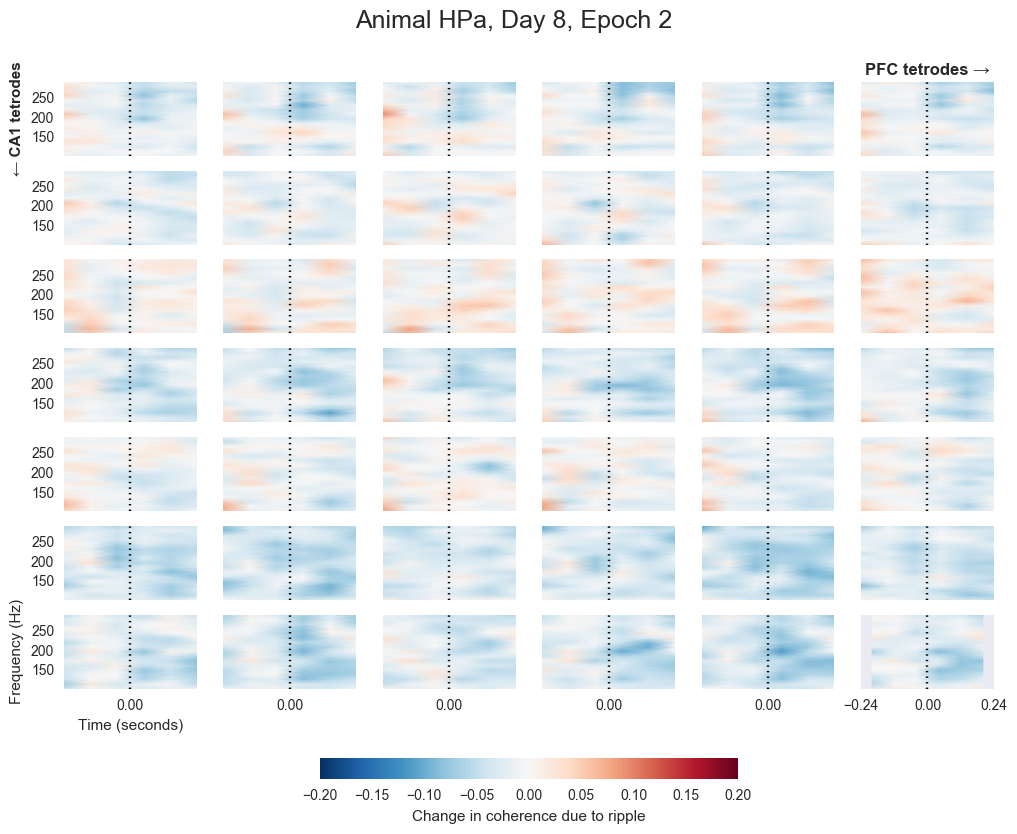

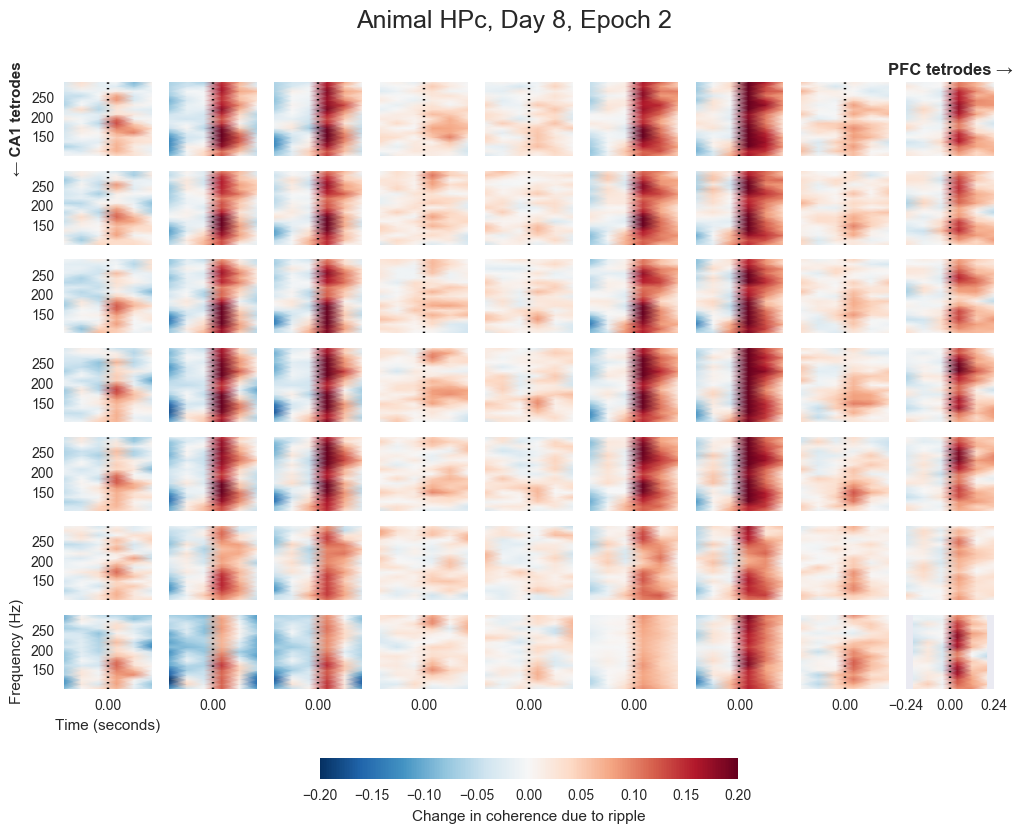

In [9]:
high_frequency_params = dict(
    baseline_window=(-0.250, 0),
    window_of_interest=(-0.240, .240),
    sampling_frequency=1500,
    time_window_duration=0.080,
    time_window_step=0.080,
    desired_frequencies=[100, 300],
    time_halfbandwidth_product=2
)

for epoch in tqdm.tqdm_notebook(epoch_index, desc='epochs'):
    cur_tetrode_info = tetrode_info[epoch][tetrode_info[epoch].area.isin(['PFC', 'CA1'])]
    lfps = data_filter.get_LFP_data(cur_tetrode_info.index, animals)
    ripple_times = ripple_detection.get_computed_consensus_ripple_times(epoch, animals)
    coherence = [spectral.difference_from_baseline_coherence(
            [lfp1, lfp2], ripple_times, **high_frequency_params)
                 for lfp1, lfp2 in itertools.combinations(lfps, 2)]
    tetrode_pair_info = epoch_pairs(cur_tetrode_info)
    plot_CA1_PFC_coherence(coherence, cur_tetrode_info, tetrode_pair_info, epoch,
                           high_frequency_params['window_of_interest'])

### Gamma Frequencies (20 - 100 Hz)
frequency resolution = 3 / 0.600 = 5 Hz


/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slic

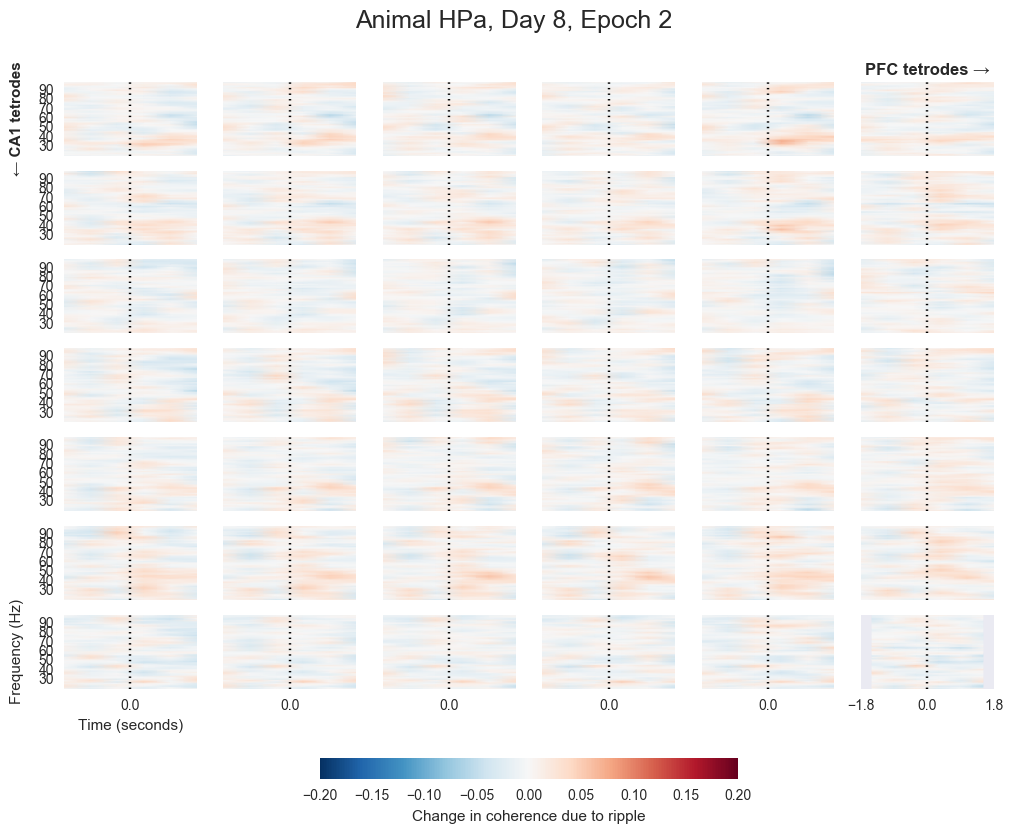

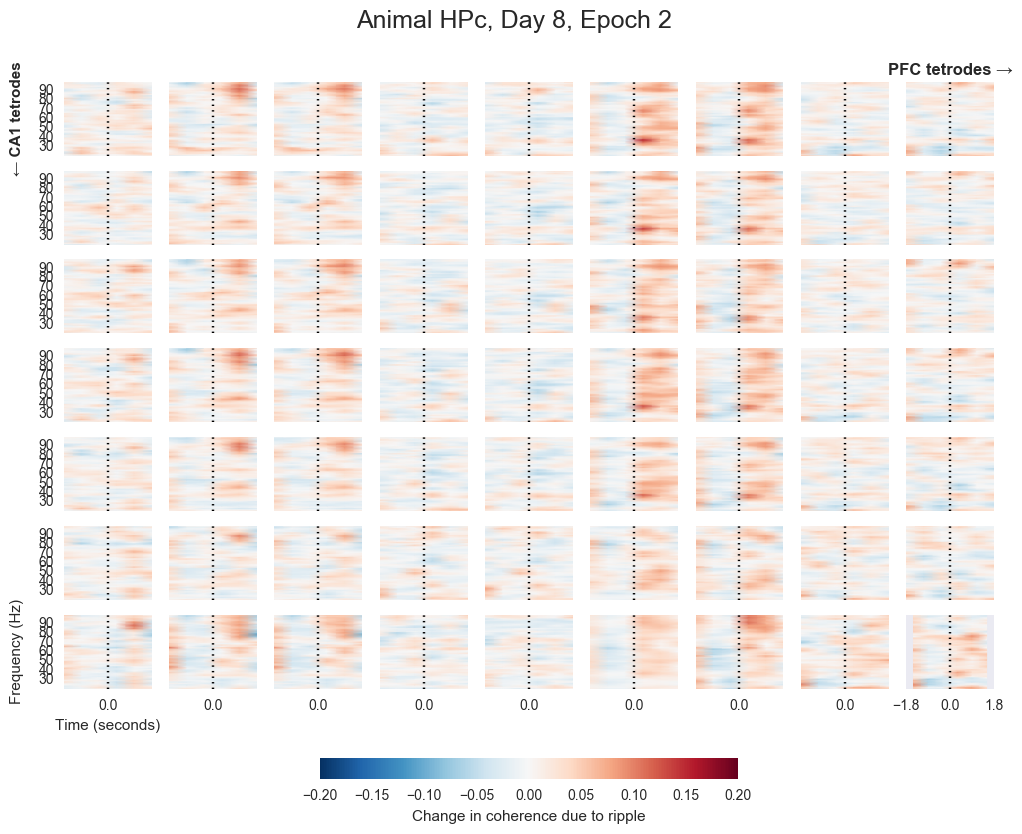

In [10]:
gamma_frequency_parms = dict(
    sampling_frequency=1500,
    time_window_duration=0.600,
    time_window_step=0.600,
    desired_frequencies=[20, 100],
    time_halfbandwidth_product=3,
    baseline_window=(-1.800, 0.000),
    window_of_interest=(-1.800, 1.800)
)

for epoch in tqdm.tqdm_notebook(epoch_index, desc='epochs'):
    cur_tetrode_info = tetrode_info[epoch][tetrode_info[epoch].area.isin(['PFC', 'CA1'])]
    lfps = data_filter.get_LFP_data(cur_tetrode_info.index, animals)
    ripple_times = ripple_detection.get_computed_consensus_ripple_times(epoch, animals)
    coherence = [spectral.difference_from_baseline_coherence(
            [lfp1, lfp2], ripple_times, **gamma_frequency_parms)
                 for lfp1, lfp2 in itertools.combinations(lfps, 2)]
    tetrode_pair_info = epoch_pairs(cur_tetrode_info)
    plot_CA1_PFC_coherence(coherence, cur_tetrode_info, tetrode_pair_info,
                           epoch, gamma_frequency_parms['window_of_interest'])

### Low Frequencies (3 - 20 Hz)
frequency resolution = 3 / 3 = 1 Hz

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slic

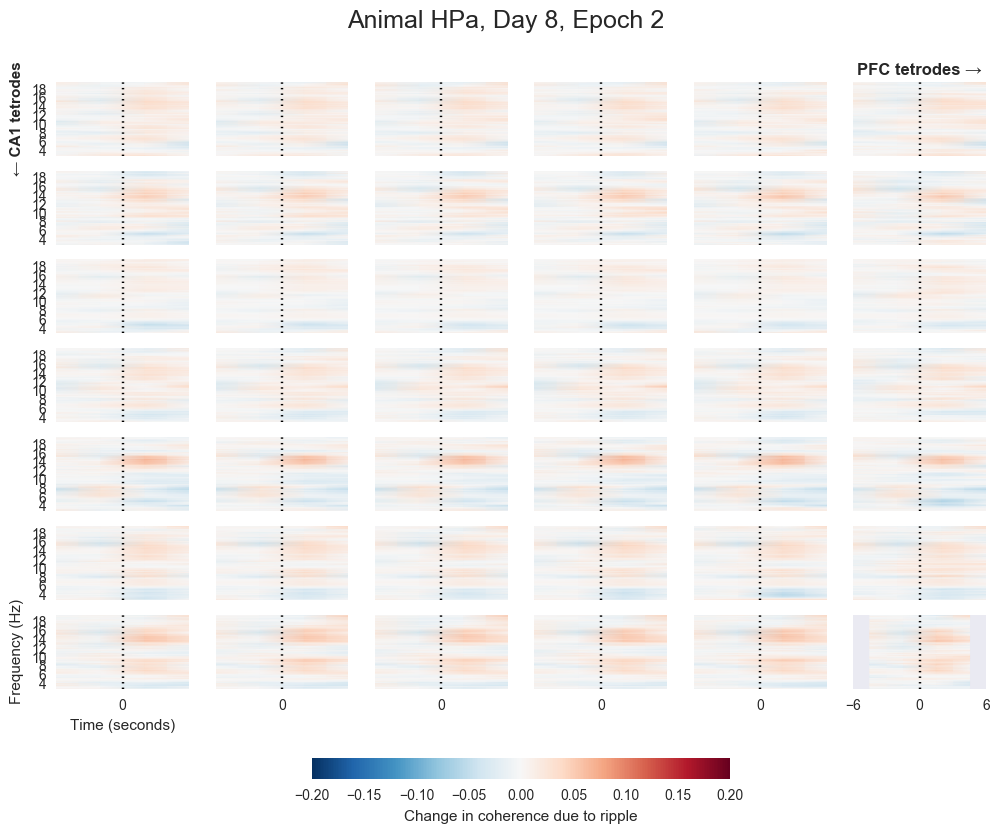

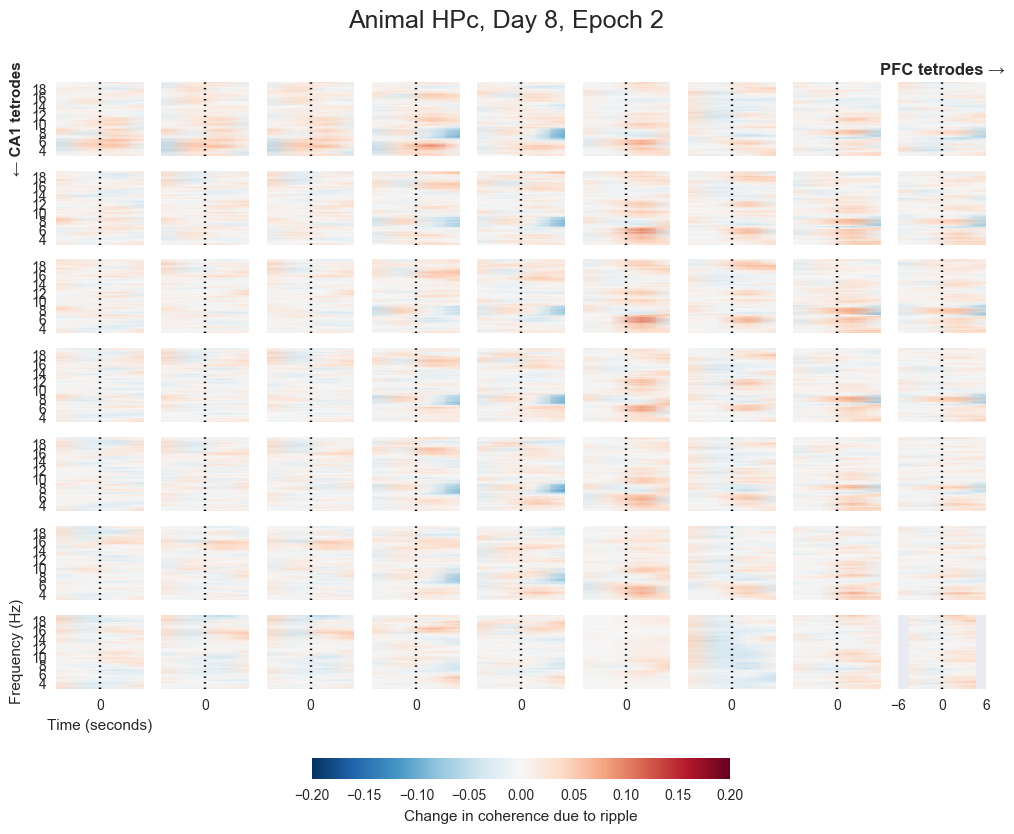

In [25]:
low_frequency_params = dict(
    sampling_frequency=1500,
    time_window_duration=3.000,
    time_window_step=3.000,
    desired_frequencies=[3, 20],
    time_halfbandwidth_product=3,
    baseline_window=(-6.000, 0.000),
    window_of_interest=(-6.000, 6.000)
)

for epoch in tqdm.tqdm_notebook(epoch_index, desc='epochs'):
    cur_tetrode_info = tetrode_info[epoch][tetrode_info[epoch].area.isin(['PFC', 'CA1'])]
    lfps = data_filter.get_LFP_data(cur_tetrode_info.index, animals)
    ripple_times = ripple_detection.get_computed_consensus_ripple_times(epoch, animals)
    coherence = [spectral.difference_from_baseline_coherence(
            [lfp1, lfp2], ripple_times, **low_frequency_params)
                 for lfp1, lfp2 in itertools.combinations(lfps, 2)]
    tetrode_pair_info = epoch_pairs(cur_tetrode_info)
    plot_CA1_PFC_coherence(coherence, cur_tetrode_info, tetrode_pair_info,
                           epoch, low_frequency_params['window_of_interest'])

## Ripple Triggered Averages

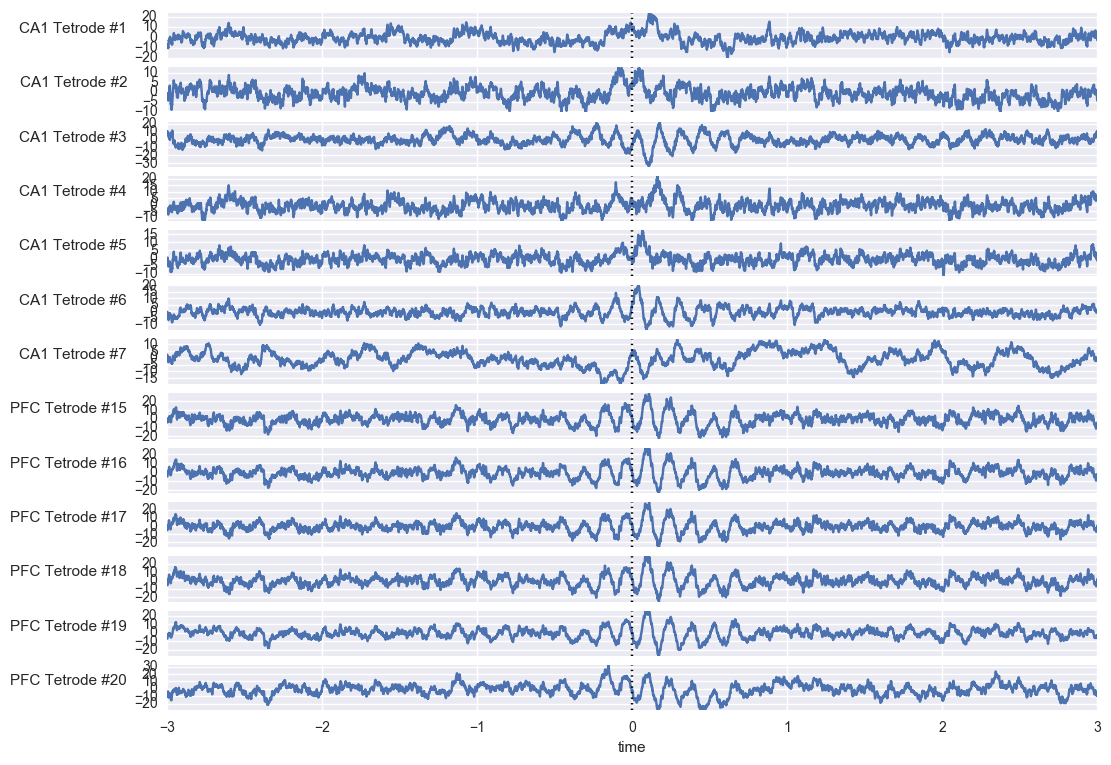

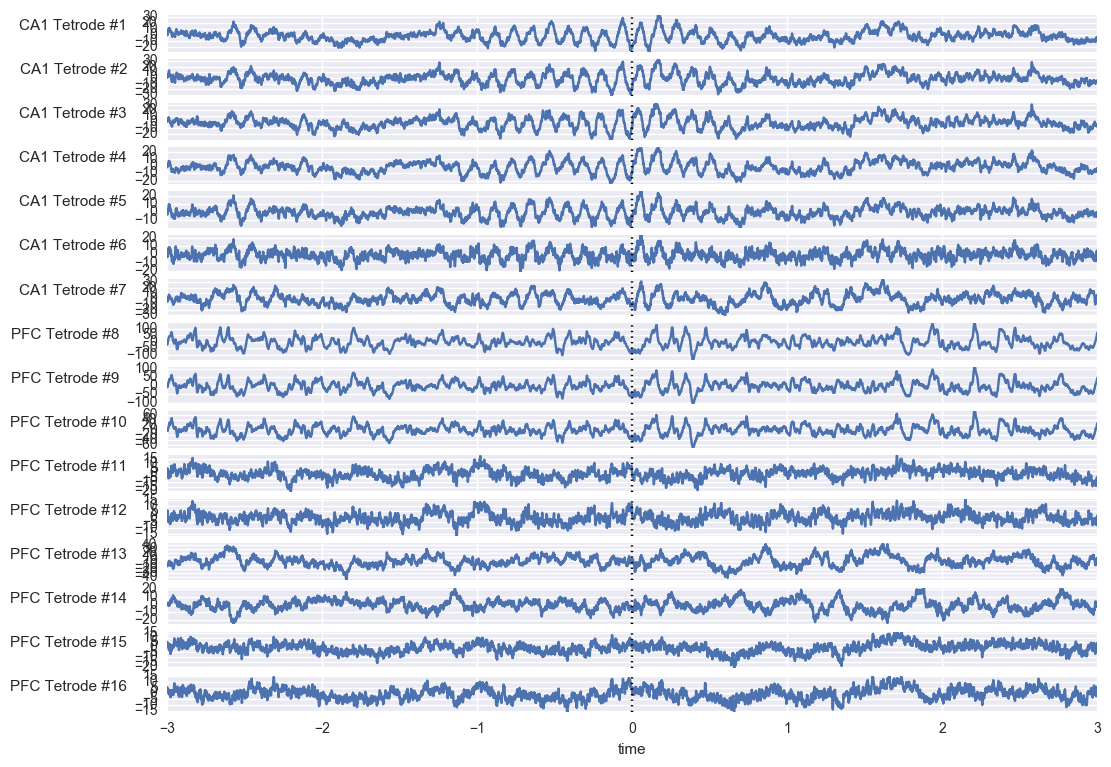

In [53]:
sampling_frequency = 1500
window_of_interest = (-3.000, 3.000)
for epoch in tqdm.tqdm_notebook(epoch_index, desc='epochs'):
    cur_tetrode_info = tetrode_info[epoch][tetrode_info[epoch].area.isin(['PFC', 'CA1'])]
    lfps = data_filter.get_LFP_data(cur_tetrode_info.index, animals)
    ripple_times = ripple_detection.get_computed_consensus_ripple_times(epoch, animals)
    time_of_interest_lfp_segments = list(ripple_detection.reshape_to_segments(
            lfps, ripple_times, window_offset=window_of_interest, concat_axis=1))

    ripple_triggered_average = [lfp.mean(axis=1) for lfp in time_of_interest_lfp_segments]
    num_lfps = len(ripple_triggered_average)

    fig, axis_handles = plt.subplots(num_lfps, 1, figsize=(12, 9), sharex=True)

    # LFP
    for ind in range(0, num_lfps):
        ripple_triggered_average[ind].plot(ax=axis_handles[ind], legend=False)
        axis_handles[ind].axvline(0, color='black', linestyle=':')
        axis_handles[ind].set_ylim((ripple_triggered_average[ind].min(),
                                    ripple_triggered_average[ind].max()))
        axis_handles[ind].set_ylabel(spectral.tetrode_title(cur_tetrode_info.index[ind], cur_tetrode_info),
                                     horizontalalignment='right',
                                     rotation='horizontal')

## Ripple Times Spectrum

In [ ]:
params = dict(
    sampling_frequency=1500,
    time_halfbandwidth_product=12,
)

def convert_ripple_times_to_dataframe(ripple_times, index):
    return (pd.DataFrame({'time': np.array(ripple_times)[:, 0], 'is_ripple': 1})
              .set_index('time')
              .reindex(index=index.values,
                       tolerance=1E-4,
                       method='nearest',
                       fill_value=0))

ripple_psd = [spectral.multitaper_power_spectral_density(
                convert_ripple_times_to_dataframe(epoch_ripple_times, epoch_lfps[0].index), **params)
              for epoch_lfps, epoch_ripple_times
              in zip(lfp_data, ripple_times)]

print(ripple_psd)

In [ ]:
ripple_psd[0].plot()
ripple_psd[1].plot()